In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")


## New with Pandas

In [2]:
from braindecode.analysis.stats import perm_mean_diff_test
import pandas as pd
from braindecode.analysis.pandas_util import round_numeric_columns
from braindecode.analysis.stats import wilcoxon_signed_rank, sign_test

def compare_csp_net(df_net, df_csp, name,freq, dataset, with_csp_acc=False, with_std=False, with_std_error=False):
    assert len(df_net) == len(df_csp), (
        "Net ({:d}) and csp ({:d}) should have same length".format(
            len(df_net), len(df_csp)))
    df_merged = df_net.merge(df_csp, on='dataset_filename', suffixes=('_net','_csp'))
    # not really necessary to sort, just to make sure 
    df_merged = df_merged.sort_values(by='dataset_filename')

    test_acc_net = np.array(df_merged['test_net'])
    test_acc_csp = np.array(df_merged['test_csp'])
    if len(test_acc_net) > 20:
        p_val = perm_mean_diff_test(test_acc_net,test_acc_csp, n_diffs=2**20)
    else:
        p_val = perm_mean_diff_test(test_acc_net,test_acc_csp, n_diffs=None)
    p_val_wilc = wilcoxon_signed_rank(test_acc_net, test_acc_csp)
    p_val_sign = sign_test(test_acc_net, test_acc_csp)
    diff_std = np.std(test_acc_net - test_acc_csp)

    df_out = pd.DataFrame()

    df_out['name'] = [name]
    df_out['freq'] = [freq]
    df_out['dataset'] = [dataset]
    if with_csp_acc:
        df_out['test_csp'] = [np.mean(test_acc_csp)]
        
    df_out['test_net'] = [np.mean(test_acc_net)]
    df_out['diff'] = [np.mean(test_acc_net) - np.mean(test_acc_csp)]
    if with_std:
        df_out['std'] = [diff_std]
    if with_std_error:
        df_out['stderr'] = [diff_std / np.sqrt(len(test_acc_net))]
    df_out = round_numeric_columns(df_out,1)
        
    
        
    df_out['rand'] = [p_val]
    df_out['wilc'] = [p_val_wilc]
    df_out['sign'] = [p_val_sign]
    df_out['time_net'] = [pd.Timedelta.round(np.mean(df_net.time), 's')]

    assert len(df_merged) == len(df_csp), (
        "Merged ({:d}) and csp ({:d}) should have same length".format(
            len(df_merged), len(df_csp)))
    return df_out

In [3]:
def elu_deep_5(df):
    return df[(df.first_nonlin == 'elu') & 
        (df.first_pool_nonlin == 'identity') &
        (df.first_pool_mode == 'max')]
def square_shallow(df):
    return df[(df.first_nonlin == 'square') & 
        (df.post_pool_nonlin == 'safe_log') &
        (df.pool_mode == 'average_exc_pad')]

def above_0(df):
    df = df[(df.cnt_preprocessors == 'resample_highpass_standardize') &
         (df.low_cut_off_hz == 'null')]
    return df

def above_4(df):
    return df[df.low_cut_off_hz == 4]

def from_0_to_4(df):
    return df[(df.high_cut_hz == 4) & 
             (df.low_cut_off_hz == "null") |  (df.low_cut_off_hz == '-')]
    
def deep_5_default(df):
    return df[(df.num_filters_4 == 200) & (df.filter_time_length == 10)]

def csp_above_0(df):
    return df[(df.min_freq == 1) & ((df.max_freq == 38) | (df.max_freq == 86))]

def csp_above_4(df):
    df = df[df.min_freq == 7]
    if 'trial_stop' in df.columns and 'max_freq' in df.columns:
        df = df[(df.trial_stop == 4000) & ((df.max_freq == 34) | (df.max_freq == 86))]
    return df

def csp_0_to_4(df):
    return df[df.max_freq == 3.5]

def tied_loss(df):
    return df[(df.loss_expression == 'tied_neighbours')]

def deep_5_new_default(df):
    df = deep_5_default(df)
    df = df[(df.layers == 'deep_5') & (df.batch_norm == True) &
         (df.layer_names_to_norms == 'layer_names_to_norms') &
         (df.drop_prob == 0.5) & 
         (df.split_first_layer == True)] # | df.split_first_layer == '-')?
    return df

def shallow_cnt_default(df):
    return df[(df.resample_fs ==250) &
         (df.final_dense_length == 30) &
         (df.layers == 'cnt_shallow_square')]

def restrict(df, **params):
    for key, val in params.iteritems():
        df = df[df[key] == val]
    return df



In [4]:
from braindecode.analysis.pandas_util import (load_data_frame,
                                              dataset_averaged_frame,
                                              remove_columns_with_same_value,
                                              remove_indices_with_same_value)

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)
df_deep_cnt_ours = load_data_frame('data/models/paper/ours/cnt/deep4/', shorten_headers=False)
df_deep_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/deep4/', shorten_headers=False)
df_shallow_cnt_ours = load_data_frame('data/models/paper/ours/cnt/shallow//', shorten_headers=False)
df_shallow_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/shallow//', shorten_headers=False)

df_deep_epo_ours = load_data_frame('data/models/paper/ours/epo/deep4/', shorten_headers=False)
df_deep_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep4/', shorten_headers=False)
df_shallow_epo_ours = load_data_frame('data/models/paper/ours/epo/shallow//', shorten_headers=False)
df_shallow_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/shallow//', shorten_headers=False)

Waiting 0.5 seconds and trying again


In [5]:
only_clean_sets = True

def clean_datasets(df):
    unclean_names = ['AnWe', 'SvMu', 'OlIl']
    for name in unclean_names:
        df = df[np.logical_not(df.dataset_filename.str.contains(name))]
    return df
def add_p_vals_to_df_row(df, test_a, test_b, n_diffs_for_large=2**20):
    assert len(test_a) == len(test_b)
    if len(test_a) > 20:
        assert len(test_a) == 29 or (len(test_a) == 26 and only_clean_sets)
        p_val = perm_mean_diff_test(test_a,test_b, n_diffs=n_diffs_for_large)
    else:
        assert len(test_a) == 9 or len(test_a) == 20 or (len(test_a) == 17 and only_clean_sets)
        p_val = perm_mean_diff_test(test_a,test_b)
    p_val_wilc = wilcoxon_signed_rank(test_a, test_b)
    p_val_sign = sign_test(test_a, test_b)
    df['rand'] = p_val
    df['wilc'] = p_val_wilc
    df['sign'] = p_val_sign
    
    
if only_clean_sets:
    df_deep_cnt_ours = clean_datasets(df_deep_cnt_ours)
    df_csp_ours = clean_datasets(df_csp_ours)
    df_shallow_cnt_ours = clean_datasets(df_shallow_cnt_ours)
    df_deep_epo_ours = clean_datasets(df_deep_epo_ours)
    df_shallow_epo_ours = clean_datasets(df_shallow_epo_ours)


    
    

## Validation CSP

In [6]:
df_valid = df_csp_bcic.copy()
df_valid = df_valid[(df_valid.resample_fs == 250) & (df_valid.max_freq == 34) & (df_valid.min_freq == 7)]


dataset_averaged_frame(remove_columns_with_same_value(df_valid))

time                  test       train     
            len    tmean   tstd  mean   std  mean  std
trial_stop                                            
4000          9 00:00:24 0 days  67.8  15.9  92.6  5.2
2500          9 00:00:20 0 days  67.6  15.1  93.6  4.1

In [7]:
test_val_theirs = [79.16,52.08,83.33,62.15,54.51,39.24,83.33,82.64,66.67]

test_val_ours_2500 = df_valid[df_valid.trial_stop == 2500].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_2500)]
df['diff'] = [np.mean(test_val_ours_2500) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_2500)
df

,test_theirs,test_ours,diff,rand,wilc,sign
0,67.01,67.59,0.58,0.78125,0.734375,1


In [8]:
test_val_ours_4000 = df_valid[df_valid.trial_stop == 4000].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_4000)]
df['diff'] = [np.mean(test_val_ours_4000) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_4000)
df

,test_theirs,test_ours,diff,rand,wilc,sign
0,67.01,67.82,0.81,0.757812,0.734375,1


## Main comparison

In [9]:
all_df = pd.DataFrame(columns=('dataset_filename', 'test_filename', 'time', 'test', 'train', 'net', 'freq', 'dataset'))

## Shallow

### BCI Competition

In [10]:
dfn = square_shallow(df_shallow_epo_bcic)
dfc = df_csp_bcic
name = 'shallow epo square'
dataset = 'bcic'
tables = []
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
    this_dfn = this_dfn[this_dfn.layers == 'cnt_shallow_square']
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'bcic', with_csp_acc=True)
    
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)
    
pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,shallow epo square,>0,bcic,67.9,69.8,1.9,0.445312,0.570312,1.000000,00:05:23
0,shallow epo square,>4,bcic,67.8,68.5,0.7,0.859375,0.570312,0.507812,00:04:22
0,shallow epo square,0-4,bcic,48.8,58.9,10.1,0.003906,0.003906,0.003906,00:07:00


In [65]:
dfn = square_shallow(df_shallow_cnt_bcic)
dfc = df_csp_bcic
name = 'shallow cnt square'
dataset = 'bcic'
tables = []
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = restrict(shallow_cnt_default(tied_loss(above_0(dfn))), drop_p='-')
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = restrict(shallow_cnt_default(tied_loss(above_4(dfn))), drop_p='-')
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
    this_dfn = this_dfn[this_dfn.layers == 'cnt_shallow_square']
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'bcic', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)
    
pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,shallow cnt square,>0,bcic,67.9,74.4,6.5,0.070312,0.097656,0.179688,00:12:03
0,shallow cnt square,>4,bcic,67.8,67.8,0.0,1.000000,0.425781,0.507812,00:10:41
0,shallow cnt square,0-4,bcic,48.8,61.4,12.6,0.023438,0.027344,0.179688,00:12:44


### Ours

In [12]:
dfn = square_shallow(df_shallow_epo_ours)
dfc = df_csp_ours
name = 'shallow epo square'
tables = []
dataset = 'ours'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
    this_dfn = this_dfn[this_dfn.layers == 'cnt_shallow_square']
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'ours', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)
    
pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,shallow epo square,>0,ours,92.1,90.3,-1.9,0.450867,0.224686,0.629059,00:19:01
0,shallow epo square,>4,ours,91.1,92.6,1.5,0.345703,0.781906,1.000000,00:22:21
0,shallow epo square,0-4,ours,68.8,75.5,6.7,0.020416,0.044769,0.332306,00:25:37


In [64]:
dfn = square_shallow(df_shallow_cnt_ours)
dfc = df_csp_ours
name = 'shallow cnt square'
tables = []
dataset = 'ours'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = restrict(shallow_cnt_default(tied_loss(above_0(dfn))), drop_p='-', tag='repl')
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = restrict(tied_loss(above_4(dfn)), drop_p='-')
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
    this_dfn = this_dfn[this_dfn.layers == 'cnt_shallow_square']
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'ours', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)

pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,shallow cnt square,>0,ours,92.1,89.0,-3.1,0.025146,0.020157,0.143463,00:31:20
0,shallow cnt square,>4,ours,91.1,93.6,2.5,0.033325,0.017426,0.012726,00:33:41
0,shallow cnt square,0-4,ours,68.8,75.6,6.8,0.011414,0.020157,0.143463,00:40:15


## Deep5

### BCI Competition

In [14]:
dfn = elu_deep_5(df_deep_epo_bcic)
dfc = df_csp_bcic
name = 'deep5 epo elu'
tables = []
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = deep_5_new_default(above_0(dfn))
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = deep_5_new_default(above_4(dfn))
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = deep_5_default(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
        this_dfn = this_dfn[this_dfn.layers == 'cnt_4l']
        this_dfn = this_dfn[this_dfn.batch_modifier == 'null']
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'bcic', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)
    

pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,deep5 epo elu,>0,bcic,67.9,70.7,2.8,0.484375,0.496094,1.000000,00:10:17
0,deep5 epo elu,>4,bcic,67.8,54.5,-13.3,0.015625,0.019531,0.179688,00:07:27
0,deep5 epo elu,0-4,bcic,48.8,60.9,12.1,0.003906,0.003906,0.003906,00:07:04


In [15]:
dfn = (elu_deep_5(df_deep_cnt_bcic))
dfc = df_csp_bcic
name = 'deep5 cnt elu'
tables = []
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = tied_loss(deep_5_new_default(above_0(dfn)))
        this_dfc = csp_above_0(dfc)
        this_dfn = this_dfn[this_dfn.batch_modifier != 'bp_meaner']
    elif band == '>4':
        this_dfn = tied_loss(deep_5_new_default(above_4(dfn)))
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(deep_5_default(from_0_to_4(dfn)))
        this_dfc = csp_0_to_4(dfc)
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'bcic', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)

pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,deep5 cnt elu,>0,bcic,67.9,70.3,2.4,0.457031,0.652344,1.000000,00:20:59
0,deep5 cnt elu,>4,bcic,67.8,65.7,-2.1,0.734375,1.089844,1.000000,00:22:44
0,deep5 cnt elu,0-4,bcic,48.8,58.7,9.9,0.105469,0.164062,0.179688,00:20:55


### Ours

In [16]:
dfn = (elu_deep_5(df_deep_epo_ours))
dfc = df_csp_ours
name = 'deep5 epo elu'
dataset = 'ours' 
tables = []
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = deep_5_new_default(above_0(dfn))
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = deep_5_new_default(above_4(dfn))
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = deep_5_new_default(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'ours', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)
    
pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,deep5 epo elu,>0,ours,92.1,89.5,-2.6,0.113159,0.026672,0.143463,00:21:53
0,deep5 epo elu,>4,ours,91.1,84.9,-6.2,0.007019,0.004639,0.012726,00:23:37
0,deep5 epo elu,0-4,ours,68.8,79.1,10.3,0.000290,0.000381,0.000275,00:17:03


In [17]:
dfn = (elu_deep_5(df_deep_cnt_ours))
dfc = df_csp_ours
name = 'deep5 cnt elu'
dataset = 'ours'
tables = []

for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = tied_loss(deep_5_new_default(above_0(dfn)))
        this_dfc = csp_above_0(dfc)
        this_dfn = this_dfn[this_dfn.batch_modifier != 'bp_meaner']
    elif band == '>4':
        this_dfn = restrict(tied_loss(deep_5_default(above_4(dfn))), drop_prob='-')
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(deep_5_default(from_0_to_4(dfn)))
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    df_out = compare_csp_net(this_dfn,this_dfc, name, band, 'ours', with_csp_acc=True)
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df = all_df.append(this_dfn)
    tables.append(df_out)

pd.concat(tables)

,name,freq,dataset,test_csp,test_net,diff,rand,wilc,sign,time_net
0,deep5 cnt elu,>0,ours,92.1,90.4,-1.7,0.216095,0.263321,0.332306,00:38:01
0,deep5 cnt elu,>4,ours,91.1,90.0,-1.1,0.453812,0.403763,0.332306,00:38:48
0,deep5 cnt elu,0-4,ours,68.8,75.2,6.4,0.044312,0.034790,0.012726,00:47:21


### Plot overall stuff


##### Add CSP to table

In [18]:
name = 'csp'
for dataset in ['bcic', 'ours']:
    for band in ['>0', '>4', '0-4']:
        if band == '>0':
            reduce_func = csp_above_0
        elif band == '>4':
            reduce_func = csp_above_4
        elif band == '0-4':
            reduce_func = csp_0_to_4
        if dataset == 'bcic':
            dfc = df_csp_bcic
        else:
            dfc = df_csp_ours
        
        dfc = reduce_func(dfc)

        dfc = remove_columns_with_same_value(dfc)
        dfc['net'] = name
        dfc['freq'] = band
        dfc['dataset'] = dataset
        all_df = all_df.append(dfc)

In [19]:
assert len(all_df) == 435 or (only_clean_sets and  len(all_df) == 390) 

##### Make comparisons

In [20]:

all_compared = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net']
all_groups = all_df.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    if net == 'csp': continue
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset)]
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    all_compared = all_compared.append(df_compare)

##### Add combined set comparisons

In [21]:
param_keys = ['freq', 'net']
all_groups = all_df.groupby(param_keys)
for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    dataset = 'combined'
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    if net == 'csp': continue
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq)]
    assert len(csp) == 29 or (len(csp) == 26 and only_clean_sets)
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    all_compared = all_compared.append(df_compare)

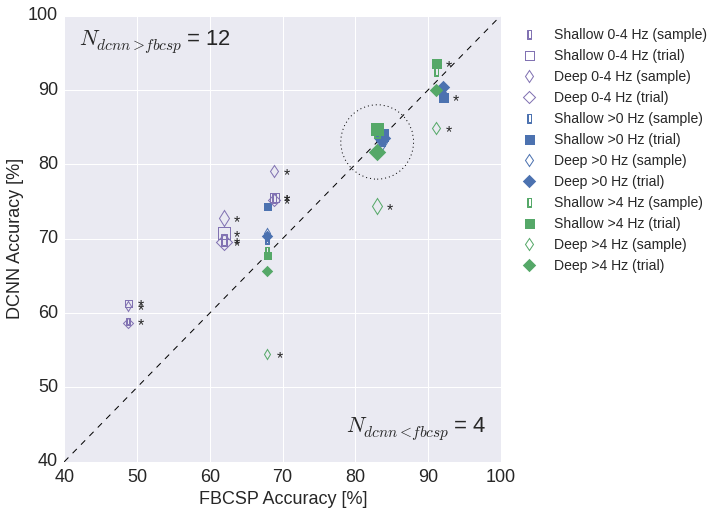

In [83]:
%config InlineBackend.figure_format = 'png' 


plt.figure(figsize=(7,7))

plt.plot([40,100], [40,100], color='black', label='', linestyle='--', lw=1)

all_labels = []
sig_count_main = []
sig_count_other = []
for dataset in ('bcic', 'ours', 'combined'):
    for freq in ('0-4', '>0', '>4'):
        for net in ('shallow', 'deep5'):
            for train_type in ('epo','cnt'):
                this_row = all_compared[(all_compared.dataset == dataset) &
                                       (all_compared.freq == freq) &
                                       (all_compared.name.str.contains(train_type) &
                                       (all_compared.name.str.contains(net)))]
                assert len(this_row) == 1
                this_row = this_row.iloc[0]
                alpha=1
                if net == 'deep5':
                    if train_type == 'cnt':
                        marker = 'D'
                    else:
                        assert train_type == 'epo'
                        marker = 'd'
                else:
                    assert net == 'shallow'
                    if train_type == 'cnt':
                        marker = 's'
                    else:
                        assert train_type == 'epo'
                        marker = ur'$\u25AF$'
                if '>0' == freq:
                    color = seaborn.color_palette()[0]
                elif '>4' == freq:
                    color = seaborn.color_palette()[1]
                else:
                    assert freq == '0-4'
                    color = seaborn.color_palette()[3]
                markerfacecolor = 'None'
                if 'bcic' == dataset:
                    markersize=7
                elif 'ours' == dataset:
                    markersize=9
                elif 'combined' == dataset:
                    markersize=12 
                
                markerfacecolor = 'None'
                if 'cnt' == train_type and freq != '0-4':
                    markerfacecolor = color
                test_csp = this_row['test_csp']
                test_net = this_row['test_net']
                
                plt.plot(test_csp, test_net, color=color, 
                         marker=marker, linestyle='None', markersize=markersize, label='dummy',
                        markerfacecolor=markerfacecolor, markeredgecolor=color,
                        markeredgewidth=1, alpha=alpha)
                
                # add significance star
                if this_row['rand'] < 0.05:
                    if 'cnt' == train_type and freq != '0-4':
                        sig_count_main.append(int(np.sign(test_net - test_csp)))
                    else:
                        sig_count_other.append(int(np.sign(test_net - test_csp)))

                    plt.annotate(
                        '*', xy = (test_csp, test_net), xytext = (10, -4), fontsize=16,
                        textcoords = 'offset points', ha = 'left', va = 'center',)



plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

plt.ylabel('DCNN Accuracy [%]', fontsize=18)

circle = plt.Circle((83,83), 5, facecolor='None', linestyle='dotted', linewidth=1)
plt.gca().add_artist(circle)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[12:30], (
                           'Shallow 0-4 Hz (sample)', 
                           'Shallow 0-4 Hz (trial)',
                           'Deep 0-4 Hz (sample)',
                           'Deep 0-4 Hz (trial)',
                           'Shallow >0 Hz (sample)', 
                           'Shallow >0 Hz (trial)',
                           'Deep >0 Hz (sample)',
                           'Deep >0 Hz (trial)',
                           'Shallow >4 Hz (sample)', 
                           'Shallow >4 Hz (trial)',
                           'Deep >4 Hz (sample)',
                           'Deep >4 Hz (trial)',),
          bbox_to_anchor=(1.5,1),fontsize=14)

plt.tight_layout()
plt.annotate(u"$N_{{dcnn>fbcsp}}$ = {:d}".format(np.sum(np.array(sig_count_main) == 1)
                                            + np.sum(np.array(sig_count_other) == 1)),xy=(42,96),
            fontsize=22)
plt.annotate(u"$N_{{dcnn<fbcsp}}$ = {:d}".format(np.sum(np.array(sig_count_main) == -1)
                                            + np.sum(np.array(sig_count_other) == -1)),xy=(98,44),
            fontsize=22, ha='right')


# We change the fontsize of minor ticks label 
plt.gca().tick_params(axis='both', which='major', labelsize=18)

# significant:
#11 5 permtest
#12 5 wilc
#10 3 sign

## Without ELU/Bnorm/Drop

In [23]:
def past(df):
    if 'cnt_shallow_square_no_bnorm' in df.layers.unique():
        df = df[df.layers == 'cnt_shallow_square_no_bnorm']
        df = df[df.drop_p == 0.]
    else:
        df = relu_deep_5(df)
        df = df[(df.layers == 'deep_5') & (df.batch_norm == False) &
         (df.drop_prob == 0.)]
    
    return df

def relu_deep_5(df):
    return df[(df.first_nonlin == 'relu') & 
        (df.first_pool_nonlin == 'identity') &
        (df.first_pool_mode == 'max')]

In [24]:
all_df_past = pd.DataFrame()


dfn = past(square_shallow(df_shallow_epo_bcic))
dfc = df_csp_bcic
name = 'shallow epo square'
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(len(this_dfn), len(this_dfc)))
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)
    

dfn = past(square_shallow(df_shallow_cnt_bcic))
dfc = df_csp_bcic
name = 'shallow cnt square'
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = tied_loss(above_0(dfn))
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = tied_loss(above_4(dfn))
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)


dfn = past(square_shallow(df_shallow_epo_ours))
dfc = df_csp_ours
name = 'shallow epo square'
dataset = 'ours'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)



dfn = past(square_shallow(df_shallow_cnt_ours))
dfc = df_csp_ours
name = 'shallow cnt square'
dataset = 'ours'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = tied_loss(above_0(dfn))
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = tied_loss(above_4(dfn))
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = tied_loss(from_0_to_4(dfn))
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)




dfn = past(df_deep_epo_bcic)
dfc = df_csp_bcic
name = 'deep5 epo relu'
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)


dfn = past(df_deep_epo_ours)
dfc = df_csp_ours
name = 'deep5 epo relu'
dataset = 'ours' 
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)

    

dfn = past(df_deep_cnt_bcic)
dfc = df_csp_bcic
name = 'deep5 cnt relu'
dataset = 'bcic'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = (above_0(dfn))
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)


dfn = past(df_deep_cnt_ours)
dfc = df_csp_ours
name = 'deep5 cnt relu'
dataset = 'ours'
for band in ['>0', '>4', '0-4']:
    if band == '>0':
        this_dfn = above_0(dfn)
        this_dfc = csp_above_0(dfc)
    elif band == '>4':
        this_dfn = above_4(dfn)
        this_dfc = csp_above_4(dfc)
    elif band == '0-4':
        this_dfn = from_0_to_4(dfn)
        this_dfc = csp_0_to_4(dfc)
        
    
    this_dfn = remove_columns_with_same_value(this_dfn)
    this_dfc = remove_columns_with_same_value(this_dfc)
    assert len(this_dfn) == len(this_dfc), (
        "Net {:d} should have as many as csp {:d}".format(
            len(this_dfn), len(this_dfc)))
    this_dfn['net'] = name
    this_dfn['freq'] = band
    this_dfn['dataset'] = dataset
    all_df_past = all_df_past.append(this_dfn)

In [25]:
assert len(all_df_past) == 348 or (only_clean_sets and  len(all_df_past) == 312) 

In [26]:


all_compared_past = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net']
all_groups = all_df_past.groupby(param_keys)

log.info("Making Comparisons")
for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    if net == 'csp': continue
    log.info("For {:s} {:s} {:s}".format(dataset, freq, net))
    # use original csp
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset)]
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    all_compared_past = all_compared_past.append(df_compare)


param_keys = ['freq', 'net']
all_groups = all_df_past.groupby(param_keys)
for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    dataset = 'combined'
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    if net == 'csp': continue
    log.info("For combined {:s} {:s}".format(freq, net))
    # use original csp
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq)]
    assert len(csp) == 29 or (len(csp) == 26 and only_clean_sets)
    df_compare = compare_csp_net(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    all_compared_past = all_compared_past.append(df_compare)

INFO:root:Making Comparisons
INFO:root:For bcic 0-4 deep5 cnt relu
INFO:root:For bcic 0-4 deep5 epo relu
INFO:root:For bcic 0-4 shallow cnt square
INFO:root:For bcic 0-4 shallow epo square
INFO:root:For bcic >0 deep5 cnt relu
INFO:root:For bcic >0 deep5 epo relu
INFO:root:For bcic >0 shallow cnt square
INFO:root:For bcic >0 shallow epo square
INFO:root:For bcic >4 deep5 cnt relu
INFO:root:For bcic >4 deep5 epo relu
INFO:root:For bcic >4 shallow cnt square
INFO:root:For bcic >4 shallow epo square
INFO:root:For ours 0-4 deep5 cnt relu
INFO:root:For ours 0-4 deep5 epo relu
INFO:root:For ours 0-4 shallow cnt square
INFO:root:For ours 0-4 shallow epo square
INFO:root:For ours >0 deep5 cnt relu
INFO:root:For ours >0 deep5 epo relu
INFO:root:For ours >0 shallow cnt square
INFO:root:For ours >0 shallow epo square
INFO:root:For ours >4 deep5 cnt relu
INFO:root:For ours >4 deep5 epo relu
INFO:root:For ours >4 shallow cnt square
INFO:root:For ours >4 shallow epo square
INFO:root:For combined 0-4 

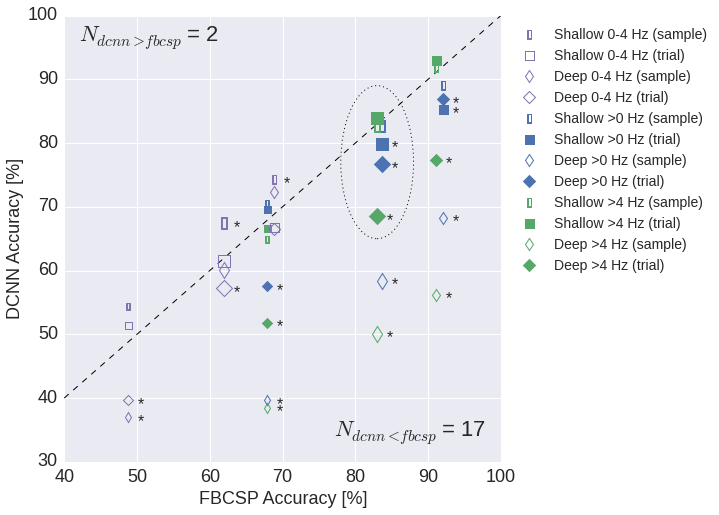

In [84]:
%config InlineBackend.figure_format = 'png' 


plt.figure(figsize=(7,7))

plt.plot([40,100], [40,100], color='black', label='', linestyle='--', lw=1)

all_labels = []
sig_count_main = []
sig_count_other = []
for dataset in ('bcic', 'ours', 'combined'):
    for freq in ('0-4', '>0', '>4'):
        for net in ('shallow', 'deep5'):
            for train_type in ('epo','cnt'):
                this_row = all_compared_past[(all_compared_past.dataset == dataset) &
                                       (all_compared_past.freq == freq) &
                                       (all_compared_past.name.str.contains(train_type) &
                                       (all_compared_past.name.str.contains(net)))]
                assert len(this_row) == 1
                this_row = this_row.iloc[0]
                alpha=1
                if net == 'deep5':
                    if train_type == 'cnt':
                        marker = 'D'
                    else:
                        assert train_type == 'epo'
                        marker = 'd'
                else:
                    assert net == 'shallow'
                    if train_type == 'cnt':
                        marker = 's'
                    else:
                        assert train_type == 'epo'
                        marker = ur'$\u25AF$'
                if '>0' == freq:
                    color = seaborn.color_palette()[0]
                elif '>4' == freq:
                    color = seaborn.color_palette()[1]
                else:
                    assert freq == '0-4'
                    color = seaborn.color_palette()[3]
                markerfacecolor = 'None'
                if 'bcic' == dataset:
                    markersize=7
                elif 'ours' == dataset:
                    markersize=9
                elif 'combined' == dataset:
                    markersize=12 
                
                markerfacecolor = 'None'
                if 'cnt' == train_type and freq != '0-4':
                    markerfacecolor = color
                test_csp = this_row['test_csp']
                test_net = this_row['test_net']
                
                plt.plot(test_csp, test_net, color=color, 
                         marker=marker, linestyle='None', markersize=markersize, label='dummy',
                        markerfacecolor=markerfacecolor, markeredgecolor=color,
                        markeredgewidth=1, alpha=alpha)
                
                # add significance star
                if this_row['rand'] < 0.05:
                    if 'cnt' == train_type and freq != '0-4':
                        sig_count_main.append(int(np.sign(test_net - test_csp)))
                    else:
                        sig_count_other.append(int(np.sign(test_net - test_csp)))

                    plt.annotate(
                        '*', xy = (test_csp, test_net), xytext = (10, -4), fontsize=16,
                        textcoords = 'offset points', ha = 'left', va = 'center',)



plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

plt.ylabel('DCNN Accuracy [%]', fontsize=18)

circle = plt.Circle((83,83), 5, facecolor='None', linestyle='dotted', linewidth=1)
ellipse = matplotlib.patches.Ellipse((83,77), 10,24,
                                    facecolor='None', linestyle='dotted', linewidth=1)
plt.gca().add_artist(ellipse)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[12:30], (
                           'Shallow 0-4 Hz (sample)', 
                           'Shallow 0-4 Hz (trial)',
                           'Deep 0-4 Hz (sample)',
                           'Deep 0-4 Hz (trial)',
                           'Shallow >0 Hz (sample)', 
                           'Shallow >0 Hz (trial)',
                           'Deep >0 Hz (sample)',
                           'Deep >0 Hz (trial)',
                           'Shallow >4 Hz (sample)', 
                           'Shallow >4 Hz (trial)',
                           'Deep >4 Hz (sample)',
                           'Deep >4 Hz (trial)',),
          bbox_to_anchor=(1.5,1),fontsize=14)

plt.tight_layout()
plt.annotate(u"$N_{{dcnn>fbcsp}}$ = {:d}".format(np.sum(np.array(sig_count_main) == 1)
                                            + np.sum(np.array(sig_count_other) == 1)),xy=(42,96),
            fontsize=22)
plt.annotate(u"$N_{{dcnn<fbcsp}}$ = {:d}".format(np.sum(np.array(sig_count_main) == -1)
                                            + np.sum(np.array(sig_count_other) == -1)),xy=(98,34),
            ha='right',
             fontsize=22)


# We change the fontsize of minor ticks label 
plt.gca().tick_params(axis='both', which='major', labelsize=18)


### Trial vs Sample

In [28]:

    
df_cnt = all_compared[(all_compared.name.str.contains('cnt'))]

df_cnt_epo = pd.DataFrame()
for i_row in xrange(len(df_cnt)):
    this_row = df_cnt.iloc[i_row,:]
    
    if this_row['dataset'] in ('bcic', 'ours'):
        this_cnt = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset'])]
    else:
        assert this_row['dataset'] == 'combined'
        this_cnt_1 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'bcic')]
        this_cnt_2 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'ours')]
        this_cnt = pd.concat((this_cnt_1, this_cnt_2))

    if this_row['dataset'] in ('bcic', 'ours'):
        this_epo = all_df[(all_df.net == this_row['name'].replace('cnt', 'epo')) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset'])]
    else:
        assert this_row['dataset'] == 'combined'
        this_epo_1 = all_df[(all_df.net == this_row['name'].replace('cnt', 'epo')) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'bcic')]
        this_epo_2 = all_df[(all_df.net == this_row['name'].replace('cnt', 'epo')) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'ours')]
        this_epo = pd.concat((this_epo_1, this_epo_2))
    this_df = pd.DataFrame()
    cnt_test = np.array(this_cnt.test)
    epo_test = np.array(this_epo.test)
        
    this_df['dataset'] = [this_row['dataset']]
    this_df['net'] = [this_row['name'].replace('cnt ', '')]
    this_df['freq'] = [this_row['freq']]
    this_df['test'] = [np.mean(epo_test)]
    this_df['diff'] = [np.mean(cnt_test - epo_test)]
    this_df['std'] = [np.std(cnt_test - epo_test)]
    this_df['stderr'] = [np.std(cnt_test - epo_test) / np.sqrt(len(cnt_test))]
    add_p_vals_to_df_row(this_df, cnt_test, epo_test)
    
    df_cnt_epo = pd.concat((df_cnt_epo, this_df))

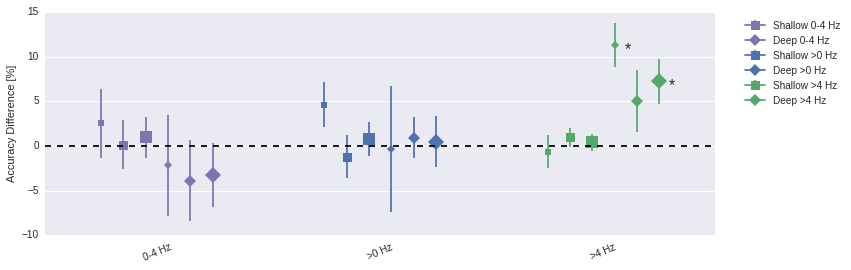

In [29]:
plt.figure(figsize=(12,4))
offset = 0
for freq in ('0-4', '>0', '>4'):
    for net in ('shallow square', 'deep5 elu'):
        for dataset in ('bcic', 'ours', 'combined'):
            if 'bcic' == dataset:
                markersize=6
            elif 'ours' == dataset:
                markersize=9
            if 'combined' == dataset:
                markersize=12
            this_row = df_cnt_epo[(df_cnt_epo.dataset == dataset) &
                                 (df_cnt_epo.freq == freq) &
                                 (df_cnt_epo.net == net)]
            label = 'dummy'
            if net == 'deep5 elu':
                marker = 'D'
            else:
                assert net == 'shallow square'
                marker = 's'
            if '0-4' == freq:
                color = seaborn.color_palette()[3]
            elif '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            plt.errorbar(offset, this_row['diff'][0], color=color,
                         yerr=this_row['stderr'][0], marker=marker,
                        markersize=markersize, label=label)
            if this_row['rand'][0] < 0.05:
                plt.annotate(
                        '*', xy = (offset, this_row['diff'][0]), xytext = (10, -4), fontsize=16,
                        textcoords = 'offset points', ha = 'left', va = 'center',)

            #plt.bar(offset,this_row['diff'][0], color=color,  width=0.1, 
            #             yerr=this_row['stderr'][0], label=label)
            offset += 0.2
    offset += 0.5
    offset = np.ceil(offset)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlim(-0.5,5.5)
plt.xticks(np.arange(0.5,5.5,2), ('0-4 Hz', '>0 Hz', '>4 Hz'), rotation=23)
plt.grid('off', axis='x')
plt.ylabel('Accuracy Difference [%]')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1::3], ('Shallow 0-4 Hz', 'Deep 0-4 Hz',
                          'Shallow >0 Hz', 'Deep >0 Hz','Shallow >4 Hz','Deep >4 Hz'), 
          bbox_to_anchor=(1.2,1))
None

### Modification Experiments

In [33]:
def square_mean_first(df):
    df = df[(df.first_nonlin == 'square') & (df.later_nonlin == 'elu') &
         (df.first_pool_mode == 'average_exc_pad') &
         (df.first_pool_nonlin == 'safe_log')]
    if len(df.layers.unique()) > 1:
        df = df[df.layers=='deep_5']
    return df

def square_max_first(df):
    df = df[(df.first_nonlin == 'square') & (df.later_nonlin == 'elu') &
         (df.first_pool_mode == 'max') &
         (df.first_pool_nonlin == 'safe_log')]
    if len(df.layers.unique()) > 1:
        df = df[df.layers=='deep_5']
    return df

def no_drop(df):
    if 'drop_prob' in df.columns:
        df = df[(df.drop_prob == 0)]
    else:
        df = df[(df.drop_p == 0)]
    return df

def no_bnorm(df):
    if 'batch_norm' in df.columns:
        df = df[df.batch_norm == False]
    else:
        df = df[df.layers == 'cnt_shallow_square_no_bnorm']
    return df

def yes_bnorm(df):
    if 'batch_norm' in df.columns:
        df = df[df.batch_norm == True]
    else:
        df = df[df.layers == 'cnt_shallow_square']
    return df

def yes_drop(df):
    if 'drop_prob' in df.columns:
        df = df[(df.drop_prob == 0.5)]
    if 'drop_p' in df.columns:
        df = df[(df.drop_p == 0.5) | (df.drop_p == '-')]
    if len(df.drop_p.unique()) > 1:
        df = df[(df.drop_p == '-')]
    return df

def no_tied_loss(df):
    df = df[df.loss_expression == 'categorical_crossentropy']
    df = df[df.trial_start == 1500]
    if hasattr(df, 'split_first_layer') and len(df.split_first_layer.unique()) > 1:
        df = df[df.split_first_layer == True]
    return df

def no_split_first_layer(df):
    if 'split_first_layer' in df.columns:
        df =  df[df.split_first_layer == False]
    else:
        df = df[df.layers == 'cnt_shallow_merged']
    if len(df.tag.unique()) > 1:
        df = df[df.tag == 'after_improvement']
    return df

def double_time_convs(df):
    df = df[(df.double_time_convs == True) & 
             (df.filter_length_4 == 6)]
    if len(df.split_first_layer.unique()) > 1:
        df = df[df.split_first_layer == True]
    return df


def square_mean_sqrt(df):
    return df[(df.post_pool_nonlin == 'safe_sqrt') &
         (df.first_nonlin == 'square')]

def elu_max_shallow(df):
    df = df[(df.first_nonlin == 'elu') &
         (df.pool_mode == 'max')]
    if len(df.drop_p.unique()) > 1:
        df = df[df.drop_p == 0.5]
    return df

def elu_mean_shallow(df):
    df = df[(df.first_nonlin == 'elu') &
         (df.pool_mode == 'average_exc_pad')]
    if len(df.drop_p.unique()) > 1:
        df = df[df.drop_p == 0.5]
    return df


def relu_nonlins(df):
    df = df[(df.first_nonlin == 'relu') & (df.later_nonlin == 'relu')]
    return df
def elu_nonlins(df):
    df = df[(df.first_nonlin == 'elu') & (df.later_nonlin == 'elu')]
    return df

In [40]:
df_mod = pd.DataFrame()
shallow_variants = [
                   ('No Dropout', lambda df: no_drop(yes_bnorm(df))),
                   ('No Batch Norm', lambda df: yes_drop(no_bnorm(df))),
                   ('No Dropout No Batch Norm', lambda df: no_drop(no_bnorm(df))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', no_tied_loss),
                   ('Sqrt instead of log', square_mean_sqrt),
                   ('Elu Max', elu_max_shallow),
                   ('Elu Mean', elu_mean_shallow),]

deep_variants = [
                   ('No Dropout', lambda df: no_drop(yes_bnorm(df))),
                   ('No Batch Norm', lambda df: yes_drop(no_bnorm(df))),
                   ('No Dropout No Batch Norm', lambda df: elu_nonlins(no_drop(no_bnorm(df)))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', no_tied_loss),
                   ('ReLU', lambda df: relu_nonlins(yes_bnorm(df))),
                   ('Log(Mean(Square)) first', square_mean_first),
                   ('Log(Max(Square)) first', square_max_first),
                   ('6x1+6x1 convs', double_time_convs),]

for dataset in 'bcic', 'ours', 'combined':
    for net in 'shallow', 'deep':
        if net == 'shallow':
            variants = shallow_variants
            net_name = 'shallow cnt square'
        else:
            assert net == 'deep'
            variants = deep_variants
            net_name = 'deep5 cnt elu'
        if dataset == 'bcic' and net == 'shallow':
            df_compare = df_shallow_cnt_bcic
        elif dataset == 'bcic' and net == 'deep':
            df_compare = df_deep_cnt_bcic
        elif dataset == 'ours' and net == 'shallow':
            df_compare = df_shallow_cnt_ours
        elif dataset == 'ours' and net == 'deep':
            df_compare = df_deep_cnt_ours
        elif dataset == 'combined' and net == 'shallow':
            df_compare = (df_shallow_cnt_bcic, df_shallow_cnt_ours)
        elif dataset == 'combined' and net == 'deep':
            df_compare = (df_deep_cnt_bcic, df_deep_cnt_ours)
            
        for freq in '>0', '>4':
            if dataset in ('bcic', 'ours'):
                df_baseline = all_df[(all_df.net == net_name)&
                                    (all_df.freq == freq) &
                                    (all_df.dataset == dataset)]
            else:
                df_baseline =  all_df[(all_df.net == net_name)&
                                    (all_df.freq == freq)]
            for var_name, var_func in variants:
                if freq == '>0' and dataset in ('bcic', 'ours'):
                    df_var = var_func(above_0(df_compare))
                elif dataset in ('bcic', 'ours'):
                    assert freq == '>4'
                    df_var = var_func(above_4(df_compare))
                elif freq == '>0' and dataset == 'combined':
                    df_var_1 = var_func(above_0(df_compare[0]))
                    df_var_2 = var_func(above_0(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                elif freq == '>4' and dataset == 'combined':
                    df_var_1 = var_func(above_4(df_compare[0]))
                    df_var_2 = var_func(above_4(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                assert len(df_var) == len(df_baseline), (
                    "Expect length of variant {:d} to be same as length of baseline {:d}".format(
                    len(df_var), len(df_baseline)))
                df_merged = df_baseline.merge(df_var, on='dataset_filename', suffixes=('_base','_var'))
                # not really necessary to sort, just to make sure 
                df_merged = df_merged.sort_values(by='dataset_filename')
                this_df_mod = pd.DataFrame()
                this_df_mod['dataset'] = [dataset]
                this_df_mod['net'] = [net]
                this_df_mod['freq'] = [freq]
                this_df_mod['variant'] = [var_name]
                this_df_mod['test'] = [np.mean(df_merged.test_var)]
                this_df_mod['diff'] = [np.mean(df_merged.test_var - df_merged.test_base)]
                this_df_mod['std'] = [np.std(df_merged.test_var - df_merged.test_base)]
                this_df_mod['stderr'] = [np.std(df_merged.test_var - df_merged.test_base) / 
                                         np.sqrt(len(df_merged))]
                
                add_p_vals_to_df_row(this_df_mod, np.array(df_merged.test_var), 
                                     np.array(df_merged.test_base), n_diffs_for_large=2**17)
                df_mod = pd.concat((df_mod, this_df_mod))
    



In [41]:
common_variants = np.intersect1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])

other_shallow_vars = np.setdiff1d(zip(*shallow_variants)[0], zip(*deep_variants)[0])[::-1]
other_deep_vars = np.setdiff1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])[::-1]
all_variants = np.concatenate((common_variants, other_shallow_vars,other_deep_vars))

uncommon_variants = np.concatenate((other_shallow_vars, other_deep_vars))

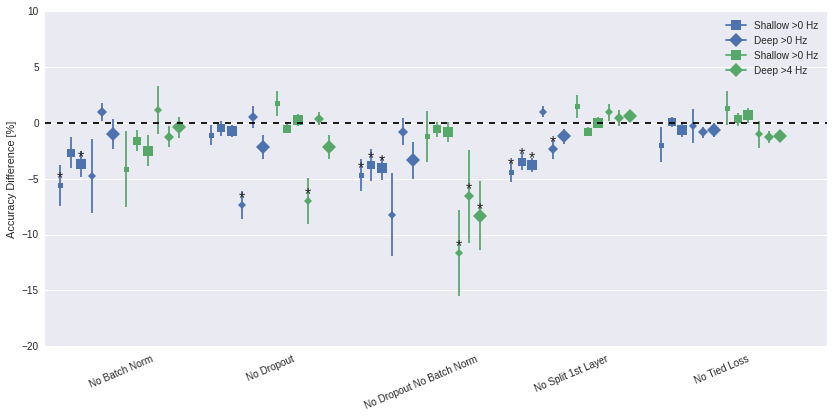

In [42]:
plt.figure(figsize=(14,6))
offset = 0
for i_var, var_name in enumerate(common_variants):
    for freq in [">0", ">4"]:
        for net in 'shallow', 'deep':
            for dataset in 'bcic', 'ours', 'combined':
                if 'bcic' == dataset:
                    markersize=5
                elif 'ours' == dataset:
                    markersize=7.5
                elif 'combined' == dataset:
                    markersize=10
                if net == 'deep':
                    marker = 'D'
                else:
                    marker = 's'
                if '>0' == freq:
                    color = seaborn.color_palette()[0]
                elif '>4' == freq:
                    color = seaborn.color_palette()[1]
                this_var = df_mod[(df_mod.variant == var_name) &
                                 (df_mod.net == net) & 
                                 (df_mod.freq == freq) & 
                                 (df_mod.dataset == dataset)]
                
                plt.errorbar(offset, this_var['diff'][0], color=color,
                             yerr=this_var['stderr'][0], marker=marker,
                            markersize=markersize, label='dummy')
                if this_var['rand'][0] < 0.05:
                    plt.annotate(
                            '*', xy = (offset, this_var['diff'][0]), xytext = (-3, 15), fontsize=16,
                            textcoords = 'offset points', ha = 'left', va = 'top',)
                offset += 0.35
        offset += 0.1
    offset += 0.5
    offset = np.ceil(offset)
plt.ylim(-20,10)
plt.axhline(y=0, color='black', linestyle='dashed')

plt.xticks(np.arange(2,4*5+3,5), common_variants, rotation=23)
plt.grid('off', axis='x')
plt.xlim(-0.5, plt.xlim()[1]+0.5)
plt.ylabel('Accuracy Difference [%]')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2::3], ('Shallow >0 Hz', 'Deep >0 Hz','Shallow >0 Hz','Deep >4 Hz'), bbox_to_anchor=(1,1))
None

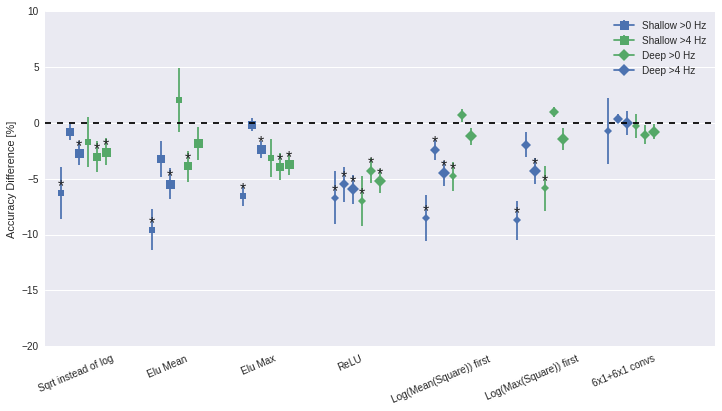

In [43]:
plt.figure(figsize=(12,6))
offset = 0
for i_var, var_name in enumerate(uncommon_variants):
    for freq in [">0", ">4"]:
        for net in 'shallow', 'deep':
            for dataset in 'bcic', 'ours', 'combined':
                if net == 'shallow' and var_name in other_deep_vars:
                    continue
                if net == 'deep' and var_name in other_shallow_vars:
                    continue
                if 'bcic' == dataset:
                    markersize=6
                elif 'ours' == dataset:
                    markersize=7.5
                if 'combined' == dataset:
                    markersize=9

                if net == 'deep':
                    marker = 'D'
                else:
                    marker = 's'
                if '>0' == freq:
                    color = seaborn.color_palette()[0]
                elif '>4' == freq:
                    color = seaborn.color_palette()[1]
                this_var = df_mod[(df_mod.variant == var_name) &
                                 (df_mod.net == net) & 
                                 (df_mod.freq == freq) & 
                                 (df_mod.dataset == dataset)]
                
                plt.errorbar(offset, this_var['diff'][0], color=color,
                             yerr=this_var['stderr'][0], marker=marker,
                            markersize=markersize, label='dummy')
                if this_var['rand'][0] < 0.05:
                    plt.annotate(
                            '*', xy = (offset, this_var['diff'][0]), xytext = (-3, 15), fontsize=16,
                            textcoords = 'offset points', ha = 'left', va = 'top',)
                offset += 0.3
    
    offset += 0.5
    offset = np.ceil(offset)
plt.ylim(-20,10)
plt.axhline(y=0, color='black', linestyle='dashed')

plt.xticks(np.arange(0.5,20.3,3), uncommon_variants, rotation=23)
plt.grid('off', axis='x')
plt.xlim(-0.5, 21.5)

plt.ylabel('Accuracy Difference [%]')


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:7:3] + handles[23:30:3],
          ('Shallow >0 Hz', 'Shallow >4 Hz','Deep >0 Hz','Deep >4 Hz'), bbox_to_anchor=(1,1))
None



## FFT Net

In [44]:
df_deep_epo_fft_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep-fft/', shorten_headers=False)
df_deep_epo_fft_ours = load_data_frame('data/models/paper/ours/epo/deep-fft/', shorten_headers=False)
if only_clean_sets:
    df_deep_epo_fft_ours = clean_datasets(df_deep_epo_fft_ours)

In [45]:
all_df_fft = pd.DataFrame()
all_df_fft_comp = pd.DataFrame()

dff = df_deep_epo_fft_bcic



dff = dff.replace({'high_cut_hz': {'undefined': '-'}})
for col in ('rejection_blink_ival', 'rejection_var_ival',
           'num_split_folds', 'whisker_percent',
           'whisker_length', 'eog_sensors', 'layer_modifier',
           'i_test_fold', 'batch_modifier', 'num_filters_simple',
           'filter_length_4', 'final_nonlin', 'max_min'):
    dff[col] = '-'
dff = dff[(dff.num_filters_time == 25) & 
         (dff.norm_axes == '-') &
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         (dff.final_pool_time_length == '-') &
         ((dff.layers == 'deep_fft_net_spat_time_freq')) &
         (dff.frequency_end != 36) &
         (dff.frequency_start != 4) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False) &
         (dff.tag != 'repl')]

dff.tag = '-'

all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, csp_above_0(df_csp_bcic),'fft','0-40','bcic',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn, csp_above_0(df_csp_bcic),'fft','0-124','bcic')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))


        
dataset_averaged_frame(remove_columns_with_same_value(dff))

time                    test       train      
                               len    tmean     tstd  mean   std  mean   std
frequency_start frequency_end                                               
0               40               9 00:02:22 00:00:29  56.4  13.9  99.9   0.2
null            null             9 00:05:00 00:01:22  44.0  14.7  96.7  10.0

In [46]:
dff = df_deep_epo_fft_ours

dff = dff.replace({'high_cut_hz': {'undefined': '-'}})
for col in ('rejection_blink_ival', 'rejection_var_ival',
           'num_split_folds', 'whisker_percent',
           'whisker_length', 'eog_sensors', 'layer_modifier',
           'i_test_fold', 'batch_modifier', 'num_filters_simple',
           'filter_length_4', 'final_nonlin', 'max_min'):
    dff[col] = '-'

dff = dff[(dff.num_filters_time == 25) & 
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         ((dff.layers == 'deep_fft_net_spat_time_freq') | (dff.layers == 'seperated_linear')) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False)]
if 'norm_axes' in dff.columns:
    dff = dff[(dff.norm_axes == '-')]
if 'final_pool_time_length' in dff.columns:
    dff = dff[(dff.final_pool_time_length == '-')]

    
all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, csp_above_0(df_csp_ours),'fft','0-40','ours',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn, csp_above_0(df_csp_ours),'fft','0-124','ours')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))
    
dataset_averaged_frame(remove_columns_with_same_value(dff))

time                    test       train     
                               len    tmean     tstd  mean   std  mean  std
frequency_end frequency_start                                              
null          null              17 00:23:54 00:10:11  83.9  10.6  99.7  1.1
40            0                 17 00:10:30 00:04:00  82.0   7.9  99.9  0.1

#### add combined

In [47]:
for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = all_df_fft[all_df_fft.frequency_end == 40]
        df_comp = compare_csp_net(this_dfn, 
                                  csp_above_0(pd.concat((df_csp_ours, df_csp_bcic))),
                                  'fft', '0-40', 'combined',)
    else:
        this_dfn = all_df_fft[all_df_fft.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_csp_net(this_dfn,
                                  csp_above_0(pd.concat((df_csp_ours, df_csp_bcic))),
                                  'fft', '0-124', 'combined')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))

In [48]:
all_df_fft_comp

,name,freq,dataset,test_net,diff,rand,wilc,sign,time_net
0,fft,0-40,bcic,56.4,-11.5,0.007812,7.812500e-03,3.906250e-02,00:02:22
0,fft,0-124,bcic,44.0,-23.9,0.003906,3.906250e-03,3.906250e-03,00:05:00
0,fft,0-40,ours,82.0,-10.1,0.000122,1.525879e-04,2.746582e-04,00:10:30
0,fft,0-124,ours,83.9,-8.2,0.000046,4.577637e-05,2.746582e-04,00:23:54
0,fft,0-40,combined,73.1,-10.6,0.000000,5.662441e-07,1.049042e-05,00:07:41
0,fft,0-124,combined,70.1,-13.6,0.000000,8.940697e-08,8.046627e-07,00:17:21


### Residual Net

In [49]:
df_resnet_bcic = load_data_frame('data/models/paper/bci-competition/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.nonlinearity != '-']
df_resnet_bcic = df_resnet_bcic.drop('final_nonlin', axis=1)
df_resnet_bcic = df_resnet_bcic.drop('batch_modifier', axis=1)

df_resnet_bcic = df_resnet_bcic.replace(dict(survival_prob={'-': 1}, final_aggregator={'-': 'pool'}, 
                                 drop_before_pool={'-': 'False'},
                                split_first_layer={'-': False}))

df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.final_aggregator == 'pool']
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.split_first_layer == True]
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.reduction_method == '-']

df_resnet_bcic = remove_columns_with_same_value(df_resnet_bcic)
averaged_frame = dataset_averaged_frame(df_resnet_bcic)


In [54]:
def no_bp_meaner(df):
    return df[df.batch_modifier != 'bp_meaner']

In [55]:
compare_csp_net(df_resnet_bcic,
                no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic))))), 
                'resnet','>0','bcic')

,name,freq,dataset,test_net,diff,rand,wilc,sign,time_net
0,resnet,>0,bcic,65.9,-4.4,0.160156,0.164062,0.179688,01:20:54


In [56]:
df_resnet_ours = load_data_frame('data/models/paper/ours/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
if only_clean_sets:
    df_resnet_ours = clean_datasets(df_resnet_ours)
df_resnet_ours = df_resnet_ours[df_resnet_ours.nonlinearity != '-']
df_resnet_ours = df_resnet_ours[df_resnet_ours.split_first_layer == True]
#df_resnet_ours = df_resnet_ours[df_resnet_ours.reduction_method == '-']
df_resnet_ours = remove_columns_with_same_value(df_resnet_ours)

averaged_frame = dataset_averaged_frame(df_resnet_ours)
averaged_frame

time                    \
                                                       len    tmean     tstd   
reduction_method reduction_pool_mode add_after_nonlin                          
pool             max                 False              17 04:52:30 01:28:57   
-                -                   -                  17 04:54:47 02:20:43   
pool             average_exc_pad     False              17 05:12:33 01:56:22   

                                                       test       train       
                                                       mean  std   mean  std  
reduction_method reduction_pool_mode add_after_nonlin                         
pool             max                 False             89.8  6.4  100.0  0.1  
-                -                   -                 89.5  6.7   99.9  0.2  
pool             average_exc_pad     False             88.3  9.1   99.9  0.2

In [59]:
df_resnet_ours = df_resnet_ours[df_resnet_ours.reduction_pool_mode == '-']
df_resnet_ours = df_resnet_ours[df_resnet_ours.add_after_nonlin == '-']

compare_csp_net(df_resnet_ours,
                no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_ours))))),
                'resnet','>0','ours')

,name,freq,dataset,test_net,diff,rand,wilc,sign,time_net
0,resnet,>0,ours,89.5,-0.9,0.671661,0.547668,1,04:54:47


In [60]:
compare_csp_net(pd.concat((df_resnet_bcic,df_resnet_ours)),
                pd.concat((
            no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic))))),
            no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_ours))))))),
                'resnet','>0','combined')

,name,freq,dataset,test_net,diff,rand,wilc,sign,time_net
0,resnet,>0,combined,81.3,-2.1,0.223517,0.129101,0.32694,03:40:45


### Training TImes

In [38]:

df_csp_ours = load_data_frame('data/models/paper/ours-before-cz-0//csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

Waiting 0.5 seconds and trying again


In [14]:
from IPython.display import display_html, display, HTML
from braindecode.analysis.pandas_util import dataset_averaged_frame, remove_columns_with_same_value, load_data_frame

In [34]:
def display_bci_competition_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    
def display_ours_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))

#### BCI Competition

In [39]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_bcic)))

time                  test       train     
   len    tmean   tstd  mean   std  mean  std
0    9 00:00:33 0 days  67.9  15.9    94  3.4

In [40]:
display_bci_competition_times('traintime-rz')

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 9 
 00:15:07 
 00:02:54 
 73.8 
 18 
 99 
 1.1

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 9 
 00:24:46 
 00:06:01 
 70 
 20.1 
 99.8 
 0.3

In [31]:
display_bci_competition_times('traintime-tf')

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 9 
 00:13:01 
 00:02:15 
 72.9 
 18.7 
 98.8 
 1.5

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 9 
 00:24:13 
 00:10:07 
 72 
 17 
 99.9 
 0.2

#### Ours

In [72]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_ours)))

time                    test      train     
   len    tmean     tstd  mean  std  mean  std
0   17 00:04:03 00:00:37  92.1  8.5  98.3  1.7

In [30]:
display_ours_times('traintime-rz')

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 17 
 00:32:12 
 00:12:22 
 89 
 8.3 
 99.9 
 0.2

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 17 
 00:49:44 
 00:23:58 
 90.4 
 8.8 
 99.8 
 0.7

In [41]:
display_ours_times('traintime-tf')

time 
 test 
 train 
 
 
 
 len 
 tmean 
 tstd 
 mean 
 std 
 mean 
 std 
 
 
 
 
 0 
 13 
 00:28:59 
 00:08:18 
 90.3 
 6.1 
 99.8 
 0.2

AttributeError: 'DataFrame' object has no attribute 'time'

In [18]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/shallow/traintime-rz/',
                                  shorten_headers=False))))

time                   test      train     
   len    tmean     tstd mean  std  mean  std
0   17 00:32:12 00:12:22   89  8.3  99.9  0.2

In [16]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/deep4/traintime-rz/',
                                  shorten_headers=False))))

time                    test      train     
   len    tmean     tstd  mean  std  mean  std
0   17 00:49:44 00:23:58  90.4  8.8  99.8  0.7

### Old trianing times, unclear which queue

In [69]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_bcic)))), drop_p='-')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

time                    test       train     
   len    tmean     tstd  mean   std  mean  std
0    9 00:12:03 00:02:38  74.4  16.1    99  0.9

In [62]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

time                    test       train     
   len    tmean     tstd  mean   std  mean  std
0    9 00:20:59 00:08:15  70.3  17.2  99.8  0.2

In [70]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_ours)))), drop_p='-', tag='repl')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

time                   test      train     
   len    tmean     tstd mean  std  mean  std
0   17 00:31:20 00:11:49   89  8.4  99.9  0.2

In [63]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_ours)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

time                    test      train     
   len    tmean     tstd  mean  std  mean  std
0   17 00:38:01 00:17:48  90.4  8.5  99.9  0.2

### New ours Run

In [133]:
remove_columns_with_same_value(load_data_frame('data/models/paper/ours-before-cz-0/csp/car/'))

,test_filename,filename,time,test,train
1,data/BBCI-only-last-runs/AnWeMoSc1S001R13_ds10...,data/BBCI-without-last-runs/AnWeMoSc1S001R01_d...,00:20:55,63.750,99.786096
2,data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10...,data/BBCI-without-last-runs/BhNoMoSc1S001R01_d...,00:20:28,99.375,99.777035
3,data/BBCI-only-last-runs/FaMaMoSc1S001R15_ds10...,data/BBCI-without-last-runs/FaMaMoSc1S001R01_d...,00:19:52,95.000,100.000000
4,data/BBCI-only-last-runs/FrThMoSc1S001R12_ds10...,data/BBCI-without-last-runs/FrThMoSc1S001R01_d...,00:20:00,86.875,100.000000
5,data/BBCI-only-last-runs/GuJoMoSc01S001R12_ds1...,data/BBCI-without-last-runs/GuJoMoSc01S001R01_...,00:20:04,62.500,100.000000
6,data/BBCI-only-last-runs/JoBeMoSc01S001R12_ds1...,data/BBCI-without-last-runs/JoBeMoSc01S001R01_...,00:19:55,86.250,100.000000
7,data/BBCI-only-last-runs/KaUsMoSc1S001R12_ds10...,data/BBCI-without-last-runs/KaUsMoSc1S001R01_d...,00:19:56,96.875,100.000000
8,data/BBCI-only-last-runs/LaKaMoSc1S001R10_ds10...,data/BBCI-without-last-runs/LaKaMoSc1S001R01_d...,00:15:22,83.125,100.000000
9,data/BBCI-only-last-runs/LuFiMoSc3S001R12_ds10...,data/BBCI-without-last-runs/LuFiMoSc3S001R01_d...,00:18:31,88.125,100.000000
10,data/BBCI-only-last-runs/MaGlMoSc2S001R13_ds10...,data/BBCI-without-last-runs/MaGlMoSc2S001R01_d...,00:21:15,96.250,99.895833


In [154]:
df_shallow_ours_new = load_data_frame('data/models/paper/ours/cnt/shallow/', shorten_headers=False)

In [155]:
avgd = dataset_averaged_frame(remove_columns_with_same_value(df_shallow_ours_new))
avgd

time  \
                                                                                                                                                                                                                 len   
drop_p high_cut_hz batch_norm_alpha layer_names_to_norms        layers                      loss_expression          first_nonlin low_cut_off_hz cnt_preprocessors             post_pool_nonlin pool_mode              
0.5    -           0.1              layer_names_to_norms        cnt_shallow_square          categorical_crossentropy square       4              resample_highpass_standardize safe_log         average_exc_pad   15   
0.0    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   18   
0.5    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   20   
                   -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   18   
0.0    -           -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   18   
0.5    -           0.1              merged_layer_names_to_norms cnt_shallow_merged          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   16   
                                    layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_sqrt        average_exc_pad   19   
                                                                                                                     elu          4              resample_highpass_standardize identity         max               19   
                                                                                                                                                                                                average_exc_pad   18   
                                                                                            categorical_crossentropy square       null           resample_highpass_standardize safe_log         average_exc_pad   20   
                                                                                            tied_neighbours          elu          null           resample_highpass_standardize identity         max               20   
                                                                                                                     square       null           resample_highpass_standardize safe_log         average_exc_pad   20   
0.0    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       null           resample_highpass_standardize safe_log         average_exc_pad   20   
0.5    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          elu          null           resample_highpass_standardize identity         average_exc_pad   20   
                                                                                                                     square       null           resample_highpass_standardize safe_sqrt        average_exc_pad   20   
                                    merged_layer_names_to_norms cnt_shallow_merged          tied_neighbours          square       null           resample_highpass_standardize safe_log         average_exc_pad   20   
                   -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbo

In [156]:
def strfdelta(tdelta, fmt):
    """For numpy timedelta, modified from
    http://stackoverflow.com/a/8907269/1469195"""
    d = {"days": tdelta.astype('timedelta64[D]').astype(np.int32)}
    # only those seconds not absorbed by day
    seconds = tdelta.astype('timedelta64[s]').astype(np.int32) % (3600 * 24)
   
    d["hours"], rem = divmod(seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [158]:
time_lens = np.array(avgd['time', 'len'])
time_means = np.array(avgd['time', 'tmean'])

n_open_exps_per_variant = 20 - time_lens
n_open_exps = np.sum(n_open_exps_per_variant)
remaining_time_per_variant = n_open_exps_per_variant * time_means

avg_time_per_exp = np.sum(time_means * time_lens) / float(np.sum(time_lens))
total_time = n_open_exps * avg_time_per_exp
print strfdelta(np.sum(remaining_time_per_variant) / 5.0, "{days} days {hours}:{minutes}:{seconds}")

0 days 2:14:10


In [148]:
df_clean = df_shallow_ours_new.copy()
unclean_names = ['AnWe', 'SvMu', 'OlIl']
for name in unclean_names:
    df_clean = df_clean[np.logical_not(df_clean.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean))
    

time  \
                                                                                                                                                                                                                 len   
drop_p high_cut_hz batch_norm_alpha layer_names_to_norms        layers                      loss_expression          first_nonlin low_cut_off_hz cnt_preprocessors             post_pool_nonlin pool_mode              
0.5    -           0.1              layer_names_to_norms        cnt_shallow_square          categorical_crossentropy square       4              resample_highpass_standardize safe_log         average_exc_pad   10   
                                    merged_layer_names_to_norms cnt_shallow_merged          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   10   
                                    layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   16   
0.0    -           -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   10   
                   0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   14   
0.5    -           -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbours          square       4              resample_highpass_standardize safe_log         average_exc_pad   12   
                   0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       4              resample_highpass_standardize safe_sqrt        average_exc_pad   16   
                                                                                                                     elu          4              resample_highpass_standardize identity         max               16   
                                                                                            categorical_crossentropy square       null           resample_highpass_standardize safe_log         average_exc_pad   17   
                                                                                            tied_neighbours          elu          4              resample_highpass_standardize identity         average_exc_pad   15   
                                                                                                                                  null           resample_highpass_standardize identity         max               17   
0.0    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       null           resample_highpass_standardize safe_log         average_exc_pad   17   
0.5    -           0.1              layer_names_to_norms        cnt_shallow_square          tied_neighbours          square       null           resample_highpass_standardize safe_log         average_exc_pad   17   
                                                                                                                                                                               safe_sqrt        average_exc_pad   17   
                                                                                                                     elu          null           resample_highpass_standardize identity         average_exc_pad   17   
                                    merged_layer_names_to_norms cnt_shallow_merged          tied_neighbours          square       null           resample_highpass_standardize safe_log         average_exc_pad   17   
                   -                layer_names_to_norms        cnt_shallow_square_no_bnorm tied_neighbo

In [131]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [132]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours))

time  \
                                                                                           len   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap        
8          250         10.0          4.0          6         1.0      86.0     3.0           20   
                                                            7.0      86.0     3.0           20   
1          100         3.5           0.5          1         0.5      3.5      0.5           20   

                                                                                                    \
                                                                                             tmean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap            
8          250         10.0          4.0          6         1.0      86.0     3.0         00:06:40   
                                                            7.0      86.0     3.0         00:06:07   
1          100         3.5           0.5          1         0.5      3.5      0.5         00:01:51   

                                                                                                    \
                                                                                              tstd   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap            
8          250         10.0          4.0          6         1.0      86.0     3.0         00:00:54   
                                                            7.0      86.0     3.0         00:00:50   
1          100         3.5           0.5          1         0.5      3.5      0.5         00:00:14   

                                                                                           test  \
                                                                                           mean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0          92.5   
                                                            7.0      86.0     3.0          90.9   
1          100         3.5           0.5          1         0.5      3.5      0.5          71.0   

                                                                                                 \
                                                                                            std   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0           8.3   
                                                            7.0      86.0     3.0           8.8   
1          100         3.5           0.5          1         0.5      3.5      0.5          13.4   

                                                                                          train  \
                                                                                           mean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0          98.5   
                                                            7.0      86.0     3.0          97.9   
1          100         3.5           0.5          1         0.5      3.5      0.5          94.0   

                                                                                                
                                                                                           std  
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap       
8          250         10.0          4.0          6         1.0      86.0     3.0          1.8  
                                                            7.0      86.0     3.0          2.0  
1    

In [66]:
df_clean_csp = df_csp_ours.copy()
unclean_names = ['AnWe', 'SvMu', 'OlIl']
for name in unclean_names:
    df_clean_csp = df_clean_csp[np.logical_not(df_clean_csp.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean_csp))
    

time  \
                                                                                           len   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap        
8          250         10.0          4.0          6         1.0      86.0     3.0           17   
                                                            7.0      86.0     3.0           17   
1          100         3.5           0.5          1         0.5      3.5      0.5           17   

                                                                                                    \
                                                                                             tmean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap            
8          250         10.0          4.0          6         1.0      86.0     3.0         00:06:35   
                                                            7.0      86.0     3.0         00:06:02   
1          100         3.5           0.5          1         0.5      3.5      0.5         00:01:50   

                                                                                                    \
                                                                                              tstd   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap            
8          250         10.0          4.0          6         1.0      86.0     3.0         00:00:57   
                                                            7.0      86.0     3.0         00:00:52   
1          100         3.5           0.5          1         0.5      3.5      0.5         00:00:15   

                                                                                           test  \
                                                                                           mean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0          92.8   
                                                            7.0      86.0     3.0          90.9   
1          100         3.5           0.5          1         0.5      3.5      0.5          69.8   

                                                                                                 \
                                                                                            std   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0           8.3   
                                                            7.0      86.0     3.0           9.2   
1          100         3.5           0.5          1         0.5      3.5      0.5          12.8   

                                                                                          train  \
                                                                                           mean   
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap         
8          250         10.0          4.0          6         1.0      86.0     3.0          98.7   
                                                            7.0      86.0     3.0          98.1   
1          100         3.5           0.5          1         0.5      3.5      0.5          93.8   

                                                                                                
                                                                                           std  
high_width resample_fs last_low_freq high_overlap low_width min_freq max_freq low_overlap       
8          250         10.0          4.0          6         1.0      86.0     3.0          1.5  
                                                            7.0      86.0     3.0          1.8  
1    